# Time Series Analysis with Deep Learning 
Time series analysis is an approach to analyze time series data to extract meaningful characteristics of data and generate other useful insights applied in business situation. 
### Steps in the process
- Preprocessing
- Define neural network shape and Model Compilation
- Fit Model
- Evaluation
- Visualize prediction
### Models
- DNNs
- RNNs
- LSTM
### Comparing Models

In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('../scripts')))
import warnings
warnings.filterwarnings('ignore')
import logging
logging.basicConfig(level=os.environ.get("LOGLEVEL", "INFO"))

In [2]:
# Importing Pandas an Numpy Libraries to use on manipulating our Data
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.preprocessing import MinMaxScaler
# To evaluate end result we have
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [6]:
import warnings
warnings.filterwarnings('ignore')
import dvc.api

### Custom library

In [5]:
from utility import ReadData
from  Preprocessing import dataPreprocess
# from logger import App_Logger
from data_info import DataInfo
import plotfunction
import util as u

In [7]:
# this train data contains the merged data and versioned with DVC
def get_data(tag, 
            path='data/train.csv', 
            repo ='C:/Users/Ekubay/Documents/Rossmann_Pharmaceutical_sales_Prediction'
):
    rev = tag
    data_url = dvc.api.get_url(path=path, repo=repo, rev=rev)
    df = pd.read_csv(data_url)
    return df

In [206]:
df_train = get_data('ver_4')

In [21]:
df_tests = get_data('ver_3')

In [94]:
df_train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,SalesperCustomer
0,1,5,5263.0,555.0,1,1,0,1,2015,7,...,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,9.482883
1,1,4,5020.0,546.0,1,1,0,1,2015,7,...,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,9.194139
2,1,3,4782.0,523.0,1,1,0,1,2015,7,...,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,9.143403
3,1,2,5011.0,560.0,1,1,0,1,2015,7,...,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,8.948214
4,1,1,6102.0,612.0,1,1,0,1,2015,7,...,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,9.970588


In [95]:
df_train.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Day', 'WeekOfYear',
       'Dates', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval',
       'SalesperCustomer'],
      dtype='object')

**need to extract**
- weekdays
- weekends 
- number of days to holidays
- Number of days after holiday
- Beginning of month, mid month and ending of month
(think of more features to extract), extra marks for it


In [209]:
train_df = df_train.copy()

In [136]:
train_df['Dates'] = pd.to_datetime(train_df['Dates'])

In [137]:
train_df['weekdays'] = train_df['Dates'].dt.weekday + 1

In [138]:
train_df['weekdays'].head()

0    5
1    4
2    3
3    2
4    1
Name: weekdays, dtype: int64

In [139]:
# weekend
train_df['Weekends'] = train_df['Dates'].dt.weekday + 1

In [141]:
train_df['Weekends'] = train_df['Weekends'].mask(train_df['Weekends'].values >= 6, 0)

In [142]:
train_df[['weekdays','Weekends']].head()

,weekdays,Weekends
0,5,5
1,4,4
2,3,3
3,2,2
4,1,1


In [154]:
train_df.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Day', 'WeekOfYear',
       'Dates', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval',
       'SalesperCustomer', 'weekdays', 'Weekends'],
      dtype='object')

In [160]:
#train_df.query('Weekends == 0')

In [158]:
train_df.Weekends.dtypes

dtype('int64')

In [49]:
df_tests.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [ ]:
df_tests.

In [16]:
df_train['Dates'].head()

0    2015-07-31
1    2015-07-30
2    2015-07-29
3    2015-07-28
4    2015-07-27
Name: Dates, dtype: object

In [50]:
df_train['Dates'] = pd.to_datetime(df_train['Dates'])

In [25]:
df_tests['Date'] = pd.to_datetime(df_tests['Date'])

In [20]:
df_train['Dates'].dtypes

dtype('<M8[ns]')

### Model 1: DNN
- A deep neural network (DNN) is an artificial neural network (ANN) with multiple layers between the input and output layers
- How to apply DNN for time-series data? The key idea here: we consider time-series as linear model

### Step 1: Data Preprocessing
Import a helper function of convert2matrix to reshape dataset in order to create 2-D input shape of DNN. A full connected net — the main difference between RNN or LTSM

In [270]:
sales_DN = df_train.groupby("Dates").agg({"Sales": "mean"})

In [271]:
sales_DN.head()

,Sales
Dates,
2013-01-01,76.940754
2013-01-02,6051.894170
2013-01-03,5578.240359
2013-01-04,5833.756951
2013-01-05,5179.874439


In [272]:
sales_df.shape

(942, 1)

In [ ]:
# scaler = StandardScaler()
# scaled_array = scaler.fit_transform(data)
# data['DataScaled'] = scaled_array

In [273]:
def convert2matrix(data_arr, look_back):
    X,Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X.append(data_arr[i:d,0])
        Y.append(data_arr[d,0])
    return np.array(X), np.array(Y)

**Split data set into testing dataset and train dataset**

In [291]:
train_size = 842
train, test =sales_df.values[0:train_size,:],sales_df.values[train_size:len(sales_df.values),:]
# setup look_back window 
look_back = 2
#convert dataset into right shape in order to input into the DNN
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)

In [292]:
trainX.shape

(840, 2)

### Step 2: Define neural network shape and compile model
I built a very simple DNN with only one hidden layer.

In [293]:
from keras.models import Sequential
from keras.layers import Dense
def model_dnn(look_back):
    model=Sequential()
    model.add(Dense(units=5, input_dim=look_back, activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',  optimizer='adam',metrics = ['mse', 'mae'])
    return model

### Step 3: Fit Model

In [294]:
from keras.callbacks import EarlyStopping
from keras.layers import Dense, SimpleRNN

In [295]:
trainX = trainX.astype(int)
trainY = trainY.astype(int)
testX = testX.astype(int)
testY = testY.astype(int)

In [296]:
mlflow.set_experiment("DNN")
mlflow.tensorflow.autolog()

2022/09/09 22:11:14 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.


In [297]:
model=model_dnn(look_back)

history=model.fit(trainX, trainY, epochs=100, batch_size=30, verbose=1, 
                  validation_data=(testX,testY),callbacks=[EarlyStopping(monitor='val_loss', 
                                                                         patience=10)], shuffle=False)

2022/09/09 22:11:21 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '96fd00d69dcb45bcad3de2c451aab4ab', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/100
 1/28 [>.............................] - ETA: 19s - loss: 38828304.0000 - mse: 38828304.0000 - mae: 5840.0806

28/28 [==============================] - 2s 35ms/step - loss: 40836468.0000 - mse: 40836468.0000 - mae: 5821.6909 - val_loss: 40444932.0000 - val_mse: 40444932.0000 - val_mae: 5705.2617
Epoch 2/100
28/28 [==============================] - 0s 15ms/step - loss: 33759936.0000 - mse: 33759936.0000 - mae: 5229.1816 - val_loss: 33523696.0000 - val_mse: 33523696.0000 - val_mae: 5224.9653
Epoch 3/100
28/28 [==============================] - 0s 8ms/step - loss: 27660914.0000 - mse: 27660914.0000 - mae: 4784.4917 - val_loss: 27389298.0000 - val_mse: 27389298.0000 - val_mae: 4777.5068
Epoch 4/100
28/28 [==============================] - 0s 8ms/step - loss: 22246616.0000 - mse: 22246616.0000 - mae: 4325.7402 - val_loss: 21956538.0000 - val_mse: 21956538.0000 - val_mae: 4298.9722
Epoch 5/100
28/28 [==============================] - 0s 7ms/step - loss: 17895228.0000 - mse: 17895228.0000 - mae: 3867.3262 - val_loss: 18034390.0000 - val_mse: 18034390.0000 - val_mae: 3867.3628
Epoch 6/100
28/28 [======

Epoch 43/100
28/28 [==============================] - 0s 12ms/step - loss: 6255844.0000 - mse: 6255844.0000 - mae: 1926.7494 - val_loss: 6937655.0000 - val_mse: 6937655.0000 - val_mae: 2026.0182
Epoch 44/100
28/28 [==============================] - 0s 11ms/step - loss: 6178319.0000 - mse: 6178319.0000 - mae: 1911.8134 - val_loss: 6858039.0000 - val_mse: 6858039.0000 - val_mae: 2012.1588
Epoch 45/100
28/28 [==============================] - 0s 9ms/step - loss: 6105185.0000 - mse: 6105185.0000 - mae: 1897.1091 - val_loss: 6783300.0000 - val_mse: 6783300.0000 - val_mae: 1998.0374
Epoch 46/100
28/28 [==============================] - 0s 11ms/step - loss: 6036906.0000 - mse: 6036906.0000 - mae: 1883.4978 - val_loss: 6712727.5000 - val_mse: 6712727.5000 - val_mae: 1984.9431
Epoch 47/100
28/28 [==============================] - 0s 13ms/step - loss: 5973493.0000 - mse: 5973493.0000 - mae: 1869.0349 - val_loss: 6648908.0000 - val_mse: 6648908.0000 - val_mae: 1971.2639
Epoch 48/100
28/28 [======

28/28 [==============================] - 0s 11ms/step - loss: 5095280.5000 - mse: 5095280.5000 - mae: 1699.0974 - val_loss: 5987929.0000 - val_mse: 5987929.0000 - val_mae: 1818.7340
Epoch 86/100
28/28 [==============================] - 0s 13ms/step - loss: 5080197.0000 - mse: 5080197.0000 - mae: 1695.8551 - val_loss: 5979266.5000 - val_mse: 5979266.5000 - val_mae: 1818.3672
Epoch 87/100
28/28 [==============================] - 0s 18ms/step - loss: 5063933.5000 - mse: 5063933.5000 - mae: 1693.7430 - val_loss: 5971518.5000 - val_mse: 5971518.5000 - val_mae: 1817.0505
Epoch 88/100
28/28 [==============================] - 0s 15ms/step - loss: 5048045.0000 - mse: 5048045.0000 - mae: 1691.3098 - val_loss: 5964172.5000 - val_mse: 5964172.5000 - val_mae: 1815.6937
Epoch 89/100
28/28 [==============================] - 0s 15ms/step - loss: 5032501.0000 - mse: 5032501.0000 - mae: 1688.8920 - val_loss: 5957064.0000 - val_mse: 5957064.0000 - val_mae: 1814.1854
Epoch 90/100
28/28 [==================

INFO:tensorflow:Assets written to: C:\Users\Ekubay\AppData\Local\Temp\tmpzwlplw7s\model\data\model\assets


### Step 4: Model evaluation

In [298]:
 def model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

4/4 [==============================] - 0s 2ms/step
Train Root Mean Squared Error(RMSE): 2207.07; Train Mean Absolute Error(MAE) : 1651.78 
Test Root Mean Squared Error(RMSE): 2429.23; Test Mean Absolute Error(MAE) : 1800.94 


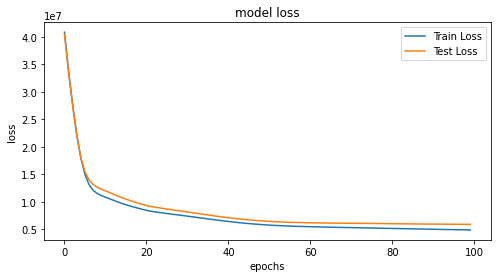

In [299]:
train_score = model.evaluate(trainX, trainY, verbose=0)
test_predict = model.predict(testX)

print('Train Root Mean Squared Error(RMSE): %.2f; Train Mean Absolute Error(MAE) : %.2f ' 
% (np.sqrt(train_score[1]), train_score[2]))
test_score = model.evaluate(testX, testY, verbose=0)
print('Test Root Mean Squared Error(RMSE): %.2f; Test Mean Absolute Error(MAE) : %.2f ' 
% (np.sqrt(test_score[1]), test_score[2]))
model_loss(history)

**Print out error metrics and generate model loss plot.**

From the graph above, obviously we overfitted our model since the model almost didn’t do anything after 40 epochs.

In [300]:
from time import gmtime, strftime
time = strftime("%Y-%m-%d-%H-%M-%S", gmtime())
model.save(f'../models/DNN_sales-{time}.pkl')

INFO:tensorflow:Assets written to: ../models/DNN_sales-2022-09-09-19-12-42.pkl\assets


### Step 5. Visualizing Prediction

In [317]:
def prediction_plot(testY, test_predict):
    len_prediction=[x for x in range(len(testY))]
    plt.figure(figsize=(8,4))
    plt.plot(len_prediction, testY[:], marker='.', label="actual")
    plt.plot(len_prediction, test_predict[:], 'r', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Sales', size=15)
    plt.xlabel('Dates', size=15)
    plt.legend(fontsize=15)
    plt.show();

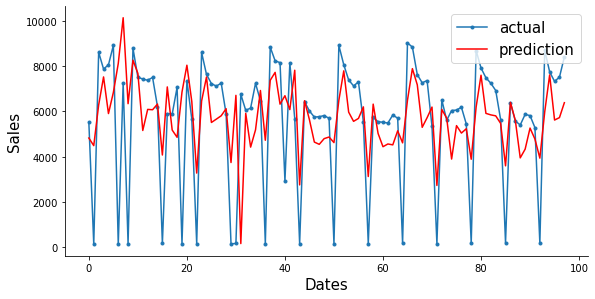

In [318]:
prediction_plot(testY, test_predict)

**From the plot, even though it misses some peaks and troughs, but it’s able to capture the overall trends and seasonality without any parameter tuning or normalization preprocessing.**

## Model 2: RNN
RNN(Recurrent Neural Network) handles sequences which is different from a fully connected DNN showed previously.

The key idea here: time-series datasets are sequences.

### Step 1: Data Preprocessing
- RNN input shape: (batch_size, window size, input_features)
- Import helper function to create matrix

In [322]:
def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X.append(data_arr[i:d,])
        Y.append(data_arr[d,])
    return np.array(X), np.array(Y)

In [323]:
train_size = 842
train,test = sales_df.values[0:train_size,:], sales_df.values[train_size:len(sales_df.values),:]
look_back = 30 #create window size as look_back=30
test = np.append(test,np.repeat(test[-1,], look_back))
train = np.append(train,np.repeat(train[-1,],look_back))
trainX,trainY =convert2matrix(train,look_back)
testX,testY =convert2matrix(test, look_back)
# reshape input to be [samples, window size, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

### Step 2: Define neural network shape and compile model

Built a RNN model with two hidden layers.

In [324]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.callbacks import EarlyStopping
def model_rnn(look_back):
    model=Sequential()
    model.add(SimpleRNN(units=32, input_shape=(1,look_back), activation="relu"))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',  optimizer='adam',metrics = ['mse', 'mae'])
    return model

### Step 3: Fit Model

In [325]:
model=model_rnn(look_back)

history=model.fit(trainX,trainY, epochs=100, batch_size=30, verbose=1, validation_data=(testX,testY),
                  callbacks=[EarlyStopping(monitor='val_loss', patience=10)],shuffle=False)

2022/09/09 22:27:51 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b2e39c4205274a1bb98cbb46adbc82a6', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/100
 1/29 [>.............................] - ETA: 26s - loss: 37272792.0000 - mse: 37272792.0000 - mae: 5643.5127

29/29 [==============================] - 2s 28ms/step - loss: 18954920.0000 - mse: 18954920.0000 - mae: 3478.1223 - val_loss: 10138290.0000 - val_mse: 10138290.0000 - val_mae: 2499.1174
Epoch 2/100
29/29 [==============================] - 0s 11ms/step - loss: 9074443.0000 - mse: 9074443.0000 - mae: 2309.2986 - val_loss: 6478343.5000 - val_mse: 6478343.5000 - val_mae: 1928.5813
Epoch 3/100
29/29 [==============================] - 0s 15ms/step - loss: 5413091.0000 - mse: 5413091.0000 - mae: 1720.5156 - val_loss: 4953994.0000 - val_mse: 4953994.0000 - val_mae: 1663.1829
Epoch 4/100
29/29 [==============================] - 0s 10ms/step - loss: 3699158.2500 - mse: 3699158.2500 - mae: 1406.7786 - val_loss: 4428832.5000 - val_mse: 4428832.5000 - val_mae: 1495.9178
Epoch 5/100
29/29 [==============================] - 0s 14ms/step - loss: 3025411.2500 - mse: 3025411.2500 - mae: 1239.8687 - val_loss: 4280258.5000 - val_mse: 4280258.5000 - val_mae: 1386.9556
Epoch 6/100
29/29 [===================

29/29 [==============================] - 0s 16ms/step - loss: 1604864.8750 - mse: 1604864.8750 - mae: 760.0820 - val_loss: 2909169.5000 - val_mse: 2909169.5000 - val_mae: 958.6122
Epoch 44/100
29/29 [==============================] - 0s 10ms/step - loss: 1597635.6250 - mse: 1597635.6250 - mae: 759.9640 - val_loss: 2916241.2500 - val_mse: 2916241.2500 - val_mae: 957.7424
Epoch 45/100
29/29 [==============================] - 1s 18ms/step - loss: 1585485.3750 - mse: 1585485.3750 - mae: 755.0694 - val_loss: 2894145.2500 - val_mse: 2894145.2500 - val_mae: 955.1470
Epoch 46/100
29/29 [==============================] - 0s 11ms/step - loss: 1576141.3750 - mse: 1576141.3750 - mae: 753.2884 - val_loss: 2884346.2500 - val_mse: 2884346.2500 - val_mae: 954.1801
Epoch 47/100
29/29 [==============================] - 0s 16ms/step - loss: 1566410.7500 - mse: 1566410.7500 - mae: 749.7863 - val_loss: 2881605.7500 - val_mse: 2881605.7500 - val_mae: 953.4582
Epoch 48/100
29/29 [============================

29/29 [==============================] - 0s 15ms/step - loss: 1293050.8750 - mse: 1293050.8750 - mae: 670.2699 - val_loss: 2550765.0000 - val_mse: 2550765.0000 - val_mae: 895.6406
Epoch 86/100
29/29 [==============================] - 1s 19ms/step - loss: 1286896.6250 - mse: 1286896.6250 - mae: 668.4465 - val_loss: 2565201.5000 - val_mse: 2565201.5000 - val_mae: 897.1041
Epoch 87/100
29/29 [==============================] - 0s 15ms/step - loss: 1283954.0000 - mse: 1283954.0000 - mae: 668.4918 - val_loss: 2564806.5000 - val_mse: 2564806.5000 - val_mae: 896.7095
Epoch 88/100
29/29 [==============================] - 0s 17ms/step - loss: 1277373.8750 - mse: 1277373.8750 - mae: 666.2368 - val_loss: 2560388.7500 - val_mse: 2560388.7500 - val_mae: 892.8119
Epoch 89/100
29/29 [==============================] - 0s 11ms/step - loss: 1272988.0000 - mse: 1272988.0000 - mae: 663.8465 - val_loss: 2540642.5000 - val_mse: 2540642.5000 - val_mae: 895.1739
Epoch 90/100
29/29 [============================

INFO:tensorflow:Assets written to: C:\Users\Ekubay\AppData\Local\Temp\tmped250dnu\model\data\model\assets


### Step 4: Model Evaluation
Print out error metrics and generate model loss plot.

In [330]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

4/4 [==============================] - 0s 2ms/step
Train Root Mean Squared Error(RMSE): 1092.96; train Mean Absolute Error(MAE) : 642.61 
Test Root Mean Squared Error(RMSE): 1572.66; test Mean Absolute Error(MAE) : 882.42 


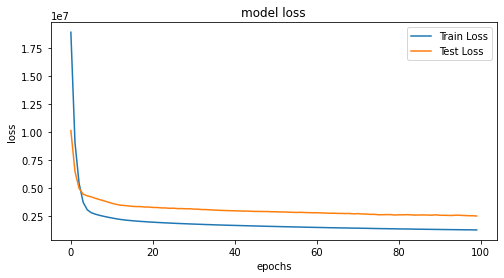

In [332]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)
print('Train Root Mean Squared Error(RMSE): %.2f; train Mean Absolute Error(MAE) : %.2f '
      % (np.sqrt(mean_squared_error(trainY, train_predict[:,0])), mean_absolute_error(trainY, train_predict[:,0])))
print('Test Root Mean Squared Error(RMSE): %.2f; test Mean Absolute Error(MAE) : %.2f ' 
      % (np.sqrt(mean_squared_error(testY, test_predict[:,0])), mean_absolute_error(testY, test_predict[:,0])))
model_loss(history)

### Step 5. Visualizing Prediction

In [351]:
def prediction_plot(testY, test_predict, look_back):
    len_prediction=[x for x in range(len(testY))]
    plt.figure(figsize=(8,4))
    plt.plot(len_prediction, testY[:], marker='.', label="actual")
    plt.plot(len_prediction, test_predict[:], 'g', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Sales', size=15)
    plt.xlabel('Dates', size=15)
    plt.legend(fontsize=15)
    plt.show();

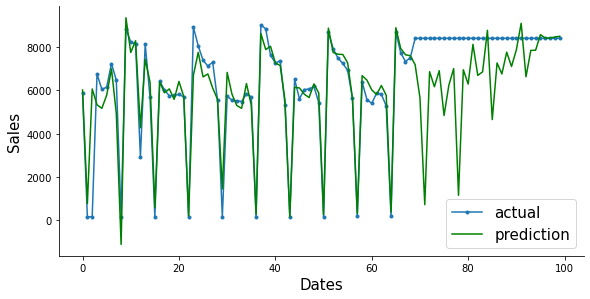

In [352]:
prediction_plot(testY, test_predict, look_back)

**In general, the prediction looks good with a smaller test errors. Even though it misses some peaks and troughs, but it’s able to capture the overall trends and seasonality.**

In [208]:
import tensorflow_addons as tfa

In [267]:
# model RNN
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Dropout, Input
from keras.models import Sequential
import tensorflow_addons as tfa


# Builds the RNN model.
def build_model(input_shape, layers, show_summary=True):
    model = Sequential()
    model.add(Input(shape=input_shape))
    for layer in layers:
        model.add(layer)

    model.compile(optimizer=tfa.optimizers.Yogi(learning_rate=0.001), loss='huber')

    if show_summary:
        model.summary()

    return model


# Fits the data into RNN.
def train(model, name, x_train, y_train, epochs=200, batch_size=32):
    checkpoint = ModelCheckpoint(filepath='weights/' + name + '_callback.h5',
                                 monitor='loss',
                                 mode='min',
                                 save_best_only=True,
                                 verbose=1)
    early_stopping = EarlyStopping(monitor='loss',
                                   min_delta=0,
                                   patience=25,
                                   verbose=1,
                                   restore_best_weights=True)

    model_callbacks = [checkpoint, early_stopping]

    history = model.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=epochs, callbacks=model_callbacks, verbose=1)
    return model, history

## Model 3: LSTM — one member of RNN families
LSTM(Long short-term memory), constructed by four main components: Input Gate, Output Gate, Memory Cell and Forget Gate

In [167]:
import numpy as np
import pandas as pd
import sys
import mlflow
import warnings
import pickle
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

## Step1: Data Preprocessing:
LSTMs are sensitive to the scale of the input data. During the Preprocessing step, I applied MinMaxScaler preprocessing class from the scikit-learn module to normalize/rescale dataset.

In [ ]:
def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
    d=i+look_back  
    X.append(data_arr[i:d,])
    Y.append(data_arr[d,])
    return np.array(X), np.array(Y)

In [172]:
sales_df = df_train.groupby("Dates").agg({"Sales": "mean"})

In [174]:
sales_df.shape

(942, 1)

In [180]:
scaler = StandardScaler()
scaled_array = scaler.fit_transform(sales_df)
data['DataScaled'] = scaled_array

In [181]:
SIZE = len(data.DataScaled)
WINDOW_SIZE = 48
BATCH_SIZE = SIZE - WINDOW_SIZE * 2
EPOCHS = 200

In [182]:
DateTrain = data.index.values[0:BATCH_SIZE]
DateValid = data.index.values[BATCH_SIZE:]
XTrain = data.DataScaled.values[0:BATCH_SIZE].astype('float32')
XValid = data.DataScaled.values[BATCH_SIZE:].astype('float32')

In [183]:
# Obtain shapes for vectors of size (,1) for dates series

DateTrain = np.reshape(DateTrain, (-1, 1))
DateValid = np.reshape(DateValid, (-1, 1))

print("Shape of the training set date series: ", DateTrain.shape)
print("Shape of the validation set date series: ", DateValid.shape)
print()
print("Shape of the training set logarithm of sales series: ", XTrain.shape)
print("Shape of the validation set logarithm of sales series in a stateless LSTM: ", XValid.shape)

Shape of the training set date series:  (846, 1)
Shape of the validation set date series:  (96, 1)

Shape of the training set logarithm of sales series:  (846,)
Shape of the validation set logarithm of sales series in a stateless LSTM:  (96,)


In [184]:
tf.random.set_seed(1234)
# add extra dimension
series = tf.expand_dims(XTrain, axis=-1)
series.shape

TensorShape([846, 1])

In [185]:
# create tensor from each individual element
dataset = tf.data.Dataset.from_tensor_slices(series)
dataset

<TensorSliceDataset element_spec=TensorSpec(shape=(1,), dtype=tf.float32, name=None)>

In [186]:
# takes a window_size + 1 chunk from the slices
dataset = dataset.window(WINDOW_SIZE + 1, shift=1, drop_remainder=True)

In [187]:
# Example of Window
datasetEx = tf.data.Dataset.from_tensor_slices(tf.range(10))
datasetEx = datasetEx.window(5, shift=1, drop_remainder=True)
for window in datasetEx:
    print([elem.numpy() for elem in window])

[0, 1, 2, 3, 4]
[1, 2, 3, 4, 5]
[2, 3, 4, 5, 6]
[3, 4, 5, 6, 7]
[4, 5, 6, 7, 8]
[5, 6, 7, 8, 9]


In [188]:
dataset = dataset.flat_map(lambda window: window.batch(WINDOW_SIZE + 1))

In [189]:
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))

In [190]:
dataset = dataset.batch(BATCH_SIZE).prefetch(1)

In [191]:
def windowed_dataset(series, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [192]:
DatasetTrain = windowed_dataset(XTrain)
DatasetVal = windowed_dataset(XValid)

## Model training 

In [236]:
model = Sequential()
model.add(LSTM(8, input_shape=[None, 1], return_sequences=True))
model.add(LSTM(4, input_shape=[None, 1]))
model.add(Dense(1))
model.compile(loss="huber_loss", optimizer='adam')

In [194]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 8)           320       
                                                                 
 lstm_1 (LSTM)               (None, 4)                 208       
                                                                 
 dense_24 (Dense)            (None, 1)                 5         
                                                                 
Total params: 533
Trainable params: 533
Non-trainable params: 0
_________________________________________________________________


In [195]:
mlflow.set_experiment("LSTM")
mlflow.tensorflow.autolog()
history = model.fit(DatasetTrain, epochs=EPOCHS, validation_data=DatasetVal, verbose=1)

2022/09/09 20:35:53 INFO mlflow.tracking.fluent: Experiment with name 'LSTM' does not exist. Creating a new experiment.
2022/09/09 20:35:53 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.
2022/09/09 20:36:00 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b127bdd57ef4457e9cc32430b44d3ed6', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/200
1/1 [==============================] - 16s 16s/step - loss: 0.4114 - val_loss: 0.3969
Epoch 2/200
1/1 [==============================] - 1s 1s/step - loss: 0.4103 - val_loss: 0.3953
Epoch 3/200
1/1 [==============================] - 1s 1s/step - loss: 0.4092 - val_loss: 0.3937
Epoch 4/200
1/1 [==============================] - 1s 1s/step - loss: 0.4082 - val_loss: 0.3922
Epoch 5/200
1/1 [==============================] - 1s 1s/step - loss: 0.4072 - val_loss: 0.3907
Epoch 6/200
1/1 [==============================] - 1s 1s/step - loss: 0.4062 - val_loss: 0.3893
Epoch 7/200
1/1 [==============================] - 1s 1s/step - loss: 0.4053 - val_loss: 0.3878
Epoch 8/200
1/1 [==============================] - 1s 1s/step - loss: 0.4045 - val_loss: 0.3864
Epoch 9/200
1/1 [==============================] - 1s 1s/step - loss: 0.4036 - val_loss: 0.3851
Epoch 10/200
1/1 [==============================] - 1s 507ms/step - loss: 0.4029 - val_loss: 0.3837
Epoch 11/200
1/1 [================

1/1 [==============================] - 1s 654ms/step - loss: 0.3883 - val_loss: 0.3647
Epoch 84/200
1/1 [==============================] - 0s 407ms/step - loss: 0.3882 - val_loss: 0.3645
Epoch 85/200
1/1 [==============================] - 0s 290ms/step - loss: 0.3880 - val_loss: 0.3644
Epoch 86/200
1/1 [==============================] - 1s 1s/step - loss: 0.3879 - val_loss: 0.3643
Epoch 87/200
1/1 [==============================] - 0s 335ms/step - loss: 0.3878 - val_loss: 0.3641
Epoch 88/200
1/1 [==============================] - 0s 281ms/step - loss: 0.3876 - val_loss: 0.3640
Epoch 89/200
1/1 [==============================] - 0s 270ms/step - loss: 0.3875 - val_loss: 0.3638
Epoch 90/200
1/1 [==============================] - 1s 803ms/step - loss: 0.3873 - val_loss: 0.3637
Epoch 91/200
1/1 [==============================] - 1s 601ms/step - loss: 0.3872 - val_loss: 0.3635
Epoch 92/200
1/1 [==============================] - 1s 754ms/step - loss: 0.3870 - val_loss: 0.3634
Epoch 93/200
1/1

1/1 [==============================] - 1s 960ms/step - loss: 0.3661 - val_loss: 0.3258
Epoch 165/200
1/1 [==============================] - 1s 677ms/step - loss: 0.3656 - val_loss: 0.3245
Epoch 166/200
1/1 [==============================] - 1s 778ms/step - loss: 0.3652 - val_loss: 0.3232
Epoch 167/200
1/1 [==============================] - 1s 713ms/step - loss: 0.3647 - val_loss: 0.3218
Epoch 168/200
1/1 [==============================] - 1s 743ms/step - loss: 0.3643 - val_loss: 0.3205
Epoch 169/200
1/1 [==============================] - 0s 301ms/step - loss: 0.3639 - val_loss: 0.3193
Epoch 170/200
1/1 [==============================] - 1s 581ms/step - loss: 0.3635 - val_loss: 0.3181
Epoch 171/200
1/1 [==============================] - 0s 375ms/step - loss: 0.3631 - val_loss: 0.3170
Epoch 172/200
1/1 [==============================] - 1s 955ms/step - loss: 0.3627 - val_loss: 0.3159
Epoch 173/200
1/1 [==============================] - 1s 899ms/step - loss: 0.3623 - val_loss: 0.3150
Epoc

INFO:tensorflow:Assets written to: C:\Users\Ekubay\AppData\Local\Temp\tmp5bysgi8t\model\data\model\assets
2022/09/09 20:41:19 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Ekubay\AppData\Local\Temp\tmp5bysgi8t\model, flavor: keras), fall back to return ['tensorflow==2.10.0', 'keras==2.10.0']. Set logging level to DEBUG to see the full traceback.


In [196]:
from time import gmtime, strftime

In [197]:
time = strftime("%Y-%m-%d-%H-%M-%S", gmtime())
model.save(f'../models/sales_LSTM-{time}.pkl')

INFO:tensorflow:Assets written to: ../models/sales_LSTM-2022-09-09-17-41-22.pkl\assets


## Using Keras

In [179]:
sales_df.head()

,Sales
Dates,
2013-01-01,76.940754
2013-01-02,6051.894170
2013-01-03,5578.240359
2013-01-04,5833.756951
2013-01-05,5179.874439


In [249]:
sales_df = train_df.groupby("Dates").agg({"Sales": "mean"})

In [250]:
sales_df.head()

,Sales
Dates,
2013-01-01,76.940754
2013-01-02,6051.894170
2013-01-03,5578.240359
2013-01-04,5833.756951
2013-01-05,5179.874439


In [217]:
def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X.append(data_arr[i:d,])
        Y.append(data_arr[d,])
    return np.array(X), np.array(Y)

In [225]:
#sales.dtypes

In [257]:
#create numpy.ndarray
from sklearn.preprocessing import MinMaxScaler
#create numpy.ndarray
df_arr= sales_df.values 
#sales_df.values = df_arr.astype('float32')
df_arr = np.reshape(df_arr, (-1, 1)) #LTSM requires more input features compared to RNN or DNN
scaler = MinMaxScaler(feature_range=(0, 1))#LTSM is senstive to the scale of features
df_arr = scaler.fit_transform(df_arr)

In [256]:
sales_df.dtypes

Sales    float64
dtype: object

In [227]:
print(len(df_arr))

942


**Split dataset into training and test dataset. Create input 3-D input shape for LSTM.**

In [258]:
train_size = 842
test_size = len(df_arr) - train_size
train, test = df_arr[0:train_size,:], df_arr[train_size:len(df_arr),:]
look_back = 30
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

## Step 2: Define neural network shape and compile model
Here, a very simple two-layer LTSM without hidden layers

In [259]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
def model_lstm(look_back):
    model=Sequential()
    model.add(LSTM(100, input_shape=(1, look_back), activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',  optimizer='adam',metrics = ['mse', 'mae'])
    return model

In [241]:
trainX.shape

(812, 1, 30)

## Step 3: Fit model

In [260]:
model=model_lstm(look_back)

history = model.fit(trainX, trainY, epochs=100, batch_size=30, 
                    validation_data=(testX, testY), callbacks=[EarlyStopping(monitor='val_loss', 
                                                                             patience=10)], verbose=1, shuffle=False)

2022/09/09 21:40:48 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '17c77aa1e9724eb1a8de6223a3e96d37', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/100
 6/28 [=====>........................] - ETA: 0s - loss: 0.3126 - mse: 0.3126 - mae: 0.5084 

28/28 [==============================] - 2s 40ms/step - loss: 0.1622 - mse: 0.1622 - mae: 0.3247 - val_loss: 0.0782 - val_mse: 0.0782 - val_mae: 0.1987
Epoch 2/100
28/28 [==============================] - 1s 19ms/step - loss: 0.0672 - mse: 0.0672 - mae: 0.1937 - val_loss: 0.0475 - val_mse: 0.0475 - val_mae: 0.1612
Epoch 3/100
28/28 [==============================] - 0s 16ms/step - loss: 0.0423 - mse: 0.0423 - mae: 0.1539 - val_loss: 0.0265 - val_mse: 0.0265 - val_mae: 0.1206
Epoch 4/100
28/28 [==============================] - 0s 17ms/step - loss: 0.0299 - mse: 0.0299 - mae: 0.1226 - val_loss: 0.0203 - val_mse: 0.0203 - val_mae: 0.0935
Epoch 5/100
28/28 [==============================] - 0s 11ms/step - loss: 0.0272 - mse: 0.0272 - mae: 0.1074 - val_loss: 0.0190 - val_mse: 0.0190 - val_mae: 0.0849
Epoch 6/100
28/28 [==============================] - 0s 12ms/step - loss: 0.0263 - mse: 0.0263 - mae: 0.1031 - val_loss: 0.0183 - val_mse: 0.0183 - val_mae: 0.0808
Epoch 7/100
28/28 [=========

Epoch 51/100
28/28 [==============================] - 0s 15ms/step - loss: 0.0150 - mse: 0.0150 - mae: 0.0719 - val_loss: 0.0116 - val_mse: 0.0116 - val_mae: 0.0682
Epoch 52/100
28/28 [==============================] - 0s 17ms/step - loss: 0.0149 - mse: 0.0149 - mae: 0.0712 - val_loss: 0.0117 - val_mse: 0.0117 - val_mae: 0.0689
Epoch 53/100
28/28 [==============================] - 0s 15ms/step - loss: 0.0148 - mse: 0.0148 - mae: 0.0713 - val_loss: 0.0117 - val_mse: 0.0117 - val_mae: 0.0690
Epoch 54/100
28/28 [==============================] - 0s 11ms/step - loss: 0.0147 - mse: 0.0147 - mae: 0.0715 - val_loss: 0.0116 - val_mse: 0.0116 - val_mae: 0.0685
Epoch 55/100
28/28 [==============================] - 0s 12ms/step - loss: 0.0146 - mse: 0.0146 - mae: 0.0711 - val_loss: 0.0116 - val_mse: 0.0116 - val_mae: 0.0681
Epoch 56/100
28/28 [==============================] - 0s 18ms/step - loss: 0.0145 - mse: 0.0145 - mae: 0.0705 - val_loss: 0.0115 - val_mse: 0.0115 - val_mae: 0.0685
Epoch 57/1

INFO:tensorflow:Assets written to: C:\Users\Ekubay\AppData\Local\Temp\tmpr44__1mp\model\data\model\assets


## Step 4: Model Evaluation
- Print out error metrics and generate model loss plot.

In [239]:
testX.shape

(70, 1, 30)

In [240]:
trainX.shape

(812, 1, 30)

In [266]:
train_predict = model.predict(trainX)
print('here')
test_predict = model.predict(testX)
print('here1')
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
trainY = scaler.inverse_transform([trainY])
print('hi')
test_predict = scaler.inverse_transform(test_predict)
testY = scaler.inverse_transform([testY])
print('Train Root Mean Squared Error(RMSE): %.2f; Train Mean Absolute Error(MAE) : %.2f '% 
      (np.sqrt(mean_squared_error(trainY[0], train_predict[:,0])),(mean_absolute_error(trainY[0], train_predict[:,0]))))
print('Test Root Mean Squared Error(RMSE): %.2f; Test Mean Absolute Error(MAE) : %.2f '% 
      (np.sqrt(mean_squared_error(testY[0], test_predict[:,0])),(mean_absolute_error(testY[0], test_predict[:,0]))))
model_loss(history)

## 5. Visualization